In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 Needed
import sklearn
from sklearn.preprocessing import Imputer

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from sklearn.decomposition import PCA
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# "Sequential" model lets us to define a stack of neural network layers
from keras.models import Sequential
# import the "core" layers:
from keras.layers import Dense, Dropout, Activation, Flatten
# CNN
from keras.layers import Convolution2D, MaxPooling2D
# import some utilities to transform our data
from keras.utils import np_utils
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import ast
import warnings
warnings.filterwarnings(action="ignore")
from numpy import loadtxt
import xgboost as xgb




/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## IMPORTING BOTH TESTING AND TRAINING DATA

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

IMDB_MOVIE_TEST_DATA = pd.read_csv('test.csv')
IMDB_MOVIE_TRAIN_DATA = pd.read_csv('train.csv')

#### this code is gonna change the dict_columns list below, replacing the NAN values for {}
** ast.literal_eval: **  Safely evaluate an expression node or a string containing a Python literal or container display. 

In [3]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
IMDB_MOVIE_TRAIN_DATA = text_to_dict(IMDB_MOVIE_TRAIN_DATA)
IMDB_MOVIE_TEST_DATA = text_to_dict(IMDB_MOVIE_TEST_DATA)

* Test Data Head

In [4]:
IMDB_MOVIE_TEST_DATA.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.85,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,{},88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.56,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,{},0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.09,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,{},6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.60,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.00,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,{},2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.22,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


* Test Data Info 

In [5]:
IMDB_MOVIE_TEST_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    4398 non-null object
budget                   4398 non-null int64
genres                   4398 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4398 non-null object
production_countries     4398 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4398 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords           

* Train Data Head

In [6]:
IMDB_MOVIE_TRAIN_DATA.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.58,...,2/20/15,93.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.25,...,8/6/04,113.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.30,...,10/10/14,105.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.17,...,3/9/12,122.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.15,...,2/5/09,118.00,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


* Train Data info

In [7]:
IMDB_MOVIE_TRAIN_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    3000 non-null object
budget                   3000 non-null int64
genres                   3000 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     3000 non-null object
production_countries     3000 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         3000 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords            

In [8]:
IMDB_MOVIE_TRAIN_DATA.describe()

,id,budget,popularity,runtime,revenue
count,"3,000.00","3,000.00","3,000.00","2,998.00","3,000.00"
mean,"1,500.50","22,531,334.11",8.46,107.86,"66,725,851.89"
std,866.17,"37,026,086.41",12.10,22.09,"137,532,326.34"
min,1.00,0.00,0.00,0.00,1.00
25%,750.75,0.00,4.02,94.00,"2,379,808.25"
50%,"1,500.50","8,000,000.00",7.37,104.00,"16,807,068.00"
75%,"2,250.25","29,000,000.00",10.89,118.00,"68,919,203.50"
max,"3,000.00","380,000,000.00",294.34,338.00,"1,519,557,910.00"


In [9]:
IMDB_MOVIE_TRAIN_DATA.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

# Budget Plot Data

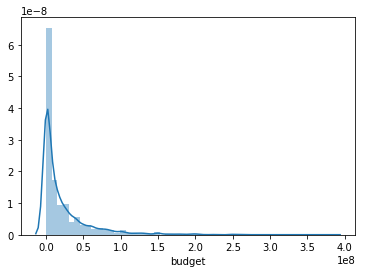

In [10]:
sns.distplot(IMDB_MOVIE_TRAIN_DATA['budget'])

* AVG BUDGET IS  4 million?

## Vizualization

In [11]:
genres= IMDB_MOVIE_TRAIN_DATA.loc[IMDB_MOVIE_TRAIN_DATA['genres'].str.len()==1][['genres','revenue','budget','popularity','runtime']].reset_index(drop=True)
genres['genres']=genres.genres.apply(lambda x :x[0]['name'])

In [12]:
genres=genres.groupby(genres.genres).agg('mean')

**Visuals  from  ** [here](https://www.kaggle.com/akumaldo/tmdb-prediction-eda-lgb-xgb-cat-plus-keras-nn)

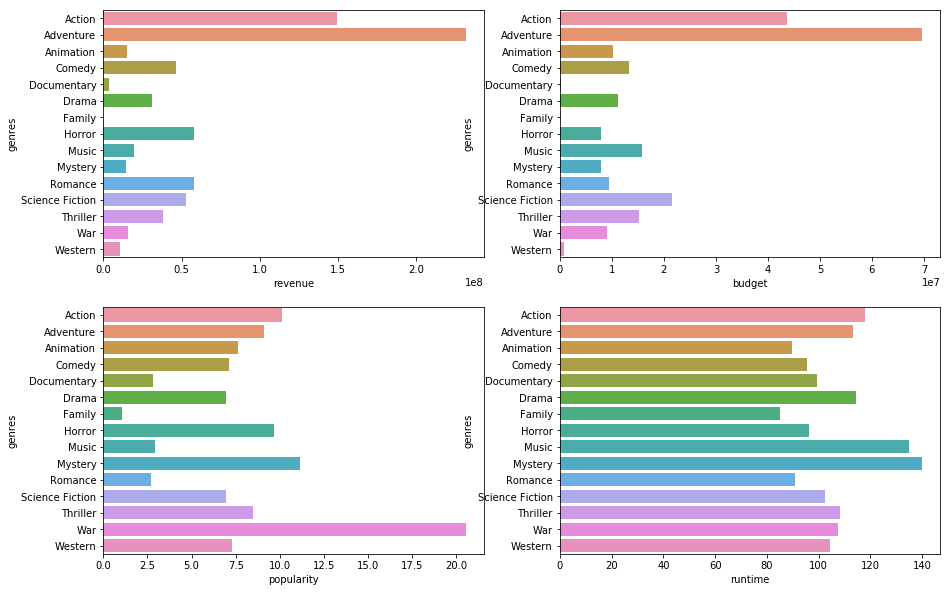

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.barplot(genres['revenue'],genres.index)

plt.subplot(2,2,2)
sns.barplot(genres['budget'],genres.index)

plt.subplot(2,2,3)
sns.barplot(genres['popularity'],genres.index)

plt.subplot(2,2,4)
sns.barplot(genres['runtime'],genres.index)

In [14]:

data = pd.concat([IMDB_MOVIE_TRAIN_DATA, IMDB_MOVIE_TEST_DATA],ignore_index=True, sort=False)

print (IMDB_MOVIE_TRAIN_DATA.shape, IMDB_MOVIE_TEST_DATA.shape, data.shape) #printing the shape

(3000, 23) (4398, 22) (7398, 23)


In [15]:

data[['release_month','release_day','release_year']]=data['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int) #getting the month year and day using the string split function and the / as a delimiter; eg: 5/25/2015 -> month 5/ day 25 / year 2015
data.loc[ (data['release_year'] <= 19) & (data['release_year'] < 100), "release_year"] += 2000 ## some rows have 4 digits for the year instead of 2, so the release year < 100 and > 100 is checking that
data.loc[ (data['release_year'] > 19)  & (data['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(data['release_date']) #using the pandas to_datetime function to format the data, get a Series,  and store it in a variable that is gonna be used later to get the day of week and quarter
data['release_dayofweek'] = releaseDate.dt.dayofweek
data['release_quarter'] = releaseDate.dt.quarter

Text(0.5,1,'Days of the week, from 0 - sunday,  to 6 - saturday')

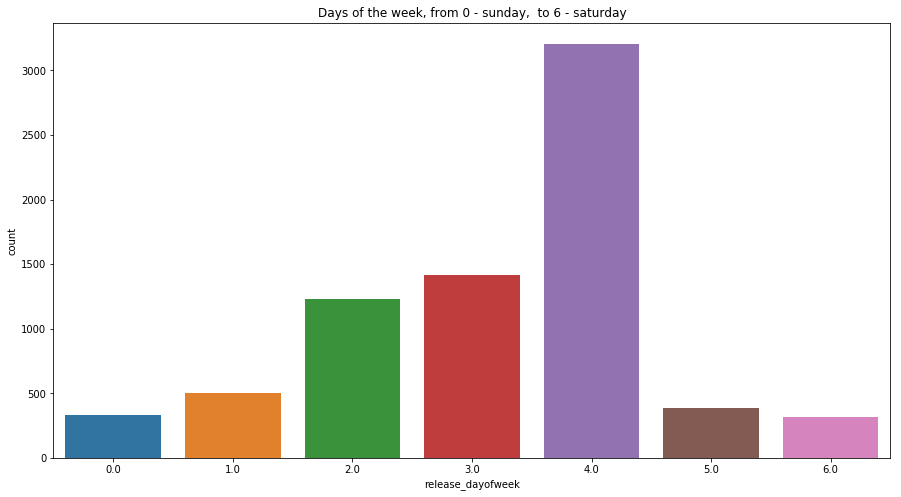

In [16]:
plt.figure(figsize=(15, 8))
sns.countplot(data['release_dayofweek'])
plt.title('Days of the week, from 0 - sunday,  to 6 - saturday')

Text(0.5,1,'Distribution of movies by month')

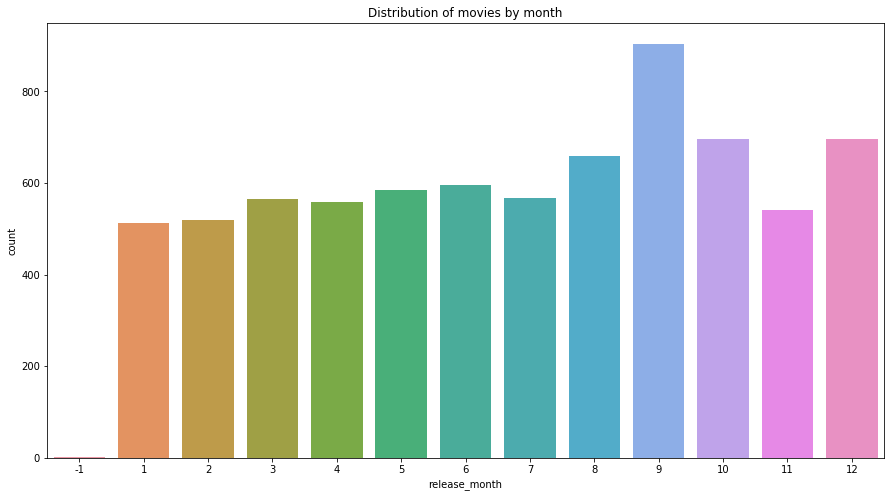

In [17]:
## -1 is the nan values in the original data, that has been replaced by -1
plt.figure(figsize=(15, 8))
sns.countplot(data['release_month']); plt.title('Distribution of movies by month')

Text(0.5,1,'Distribution of movies by days in a month')

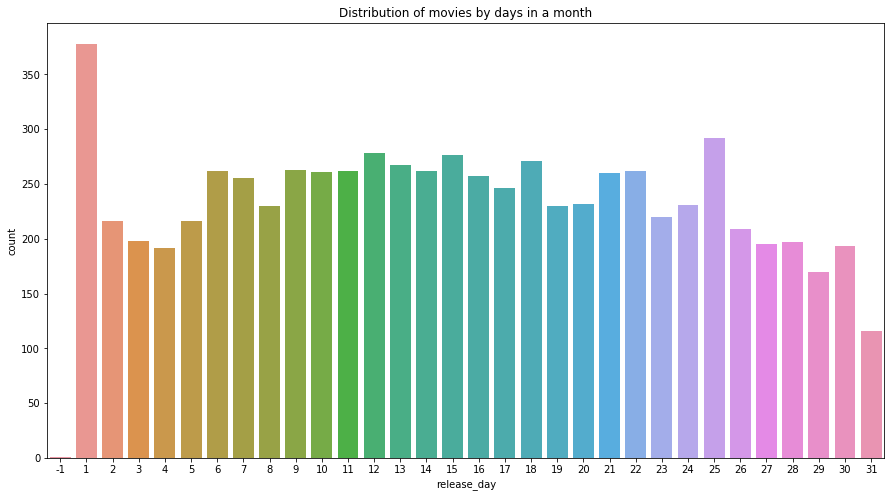

In [18]:
plt.figure(figsize=(15, 8))
sns.countplot(data['release_day']); plt.title('Distribution of movies by days in a month')

## DISPLAYING TESTING DATA

In [19]:
IMDB_MOVIE_TEST_DATA.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.85,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,{},88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.56,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,{},0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.09,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,{},6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.60,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.00,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,{},2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.22,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


## DISPLAYING TRAINING DATA

In [20]:
IMDB_MOVIE_TRAIN_DATA.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.58,...,2/20/15,93.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.25,...,8/6/04,113.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.30,...,10/10/14,105.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.17,...,3/9/12,122.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.15,...,2/5/09,118.00,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


##  Prepare Data

In [21]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

**Method from   ** [here](https://www.kaggle.com/alexandermelde/code-template-for-simple-regression-prediction/comments)



In [22]:
# This function will be called later to prepare our input data
def prepare_data(df):
    # a.) Use the `id` feature as the index column of the data frame
    df = df.set_index('id')

    # b.) Only use easy to process features
    #  Warning: huge information loss here, you should propably include more features in your production code.
    df = df[['budget', 'original_language' ,'popularity', 'runtime', 'status']]
    
    # c.) One-Hot-Encoding for all nominal data
    df = pd.get_dummies(df)
    
    # d.) The `runtime` feature is not filled in 2 of the rows. We replace those empty cells / NaN values with a 0.
    #  Warning: in production code, please use a better method to deal with missing cells like interpolation or additional `is_missing` feature columns.
    return df.fillna(0)


# 1.) Extract the target variable `revenue` and use the `id` column as index of that data frame
df_train_y = IMDB_MOVIE_TRAIN_DATA[['id','revenue']].set_index('id')

# 2.) Prepare the training and test data by using the function we defined above
df_train_x = prepare_data(IMDB_MOVIE_TRAIN_DATA)
df_test_x  = prepare_data(IMDB_MOVIE_TEST_DATA)

# 3.) Create columns in train/test dataframes if they only exist in one of them (can happen through one hot encoding / get_dummies)
#  Example: There are no status=`Post Production` entries in the training set, but there are some in the test set.
df_train_x, df_test_x = df_train_x.align(df_test_x, join='outer', axis=1, fill_value=0)

# 4.) Show the first rows of one of the prepared tables
df_train_x.head(10)

,budget,original_language_af,original_language_ar,original_language_bm,original_language_bn,original_language_ca,original_language_cn,original_language_cs,original_language_da,original_language_de,original_language_el,original_language_en,original_language_es,original_language_fa,original_language_fi,original_language_fr,original_language_he,original_language_hi,original_language_hu,original_language_id,original_language_is,original_language_it,original_language_ja,original_language_ka,original_language_kn,original_language_ko,original_language_ml,original_language_mr,original_language_nb,original_language_nl,original_language_no,original_language_pl,original_language_pt,original_language_ro,original_language_ru,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_th,original_language_tr,original_language_ur,original_language_vi,original_language_xx,original_language_zh,popularity,runtime,status_Post Production,status_Released,status_Rumored
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.58,93.00,0,1,0
2,40000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.25,113.00,0,1,0
3,3300000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64.30,105.00,0,1,0
4,1200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.17,122.00,0,1,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.15,118.00,0,1,0
6,8000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.74,83.00,0,1,0
7,14000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.29,92.00,0,1,0
8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.95,84.00,0,1,0
9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.90,100.00,0,1,0


In [23]:
df_test_x.head(10)

,budget,original_language_af,original_language_ar,original_language_bm,original_language_bn,original_language_ca,original_language_cn,original_language_cs,original_language_da,original_language_de,original_language_el,original_language_en,original_language_es,original_language_fa,original_language_fi,original_language_fr,original_language_he,original_language_hi,original_language_hu,original_language_id,original_language_is,original_language_it,original_language_ja,original_language_ka,original_language_kn,original_language_ko,original_language_ml,original_language_mr,original_language_nb,original_language_nl,original_language_no,original_language_pl,original_language_pt,original_language_ro,original_language_ru,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_th,original_language_tr,original_language_ur,original_language_vi,original_language_xx,original_language_zh,popularity,runtime,status_Post Production,status_Released,status_Rumored
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.85,90.00,0,1,0
3002,88000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.56,65.00,0,1,0
3003,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.09,100.00,0,1,0
3004,6800000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.60,130.00,0,1,0
3005,2000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.22,92.00,0,1,0
3006,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.68,121.00,0,1,0
3007,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.90,119.00,0,1,0
3008,30000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.02,77.00,0,1,0
3009,16500000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.83,120.00,0,1,0


In [24]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 50 columns):
budget                    3000 non-null int64
original_language_af      3000 non-null int64
original_language_ar      3000 non-null uint8
original_language_bm      3000 non-null int64
original_language_bn      3000 non-null uint8
original_language_ca      3000 non-null int64
original_language_cn      3000 non-null uint8
original_language_cs      3000 non-null uint8
original_language_da      3000 non-null uint8
original_language_de      3000 non-null uint8
original_language_el      3000 non-null uint8
original_language_en      3000 non-null uint8
original_language_es      3000 non-null uint8
original_language_fa      3000 non-null uint8
original_language_fi      3000 non-null uint8
original_language_fr      3000 non-null uint8
original_language_he      3000 non-null uint8
original_language_hi      3000 non-null uint8
original_language_hu      3000 non-null uint8
original_language_i

* getting rid of original languages except english

In [25]:
df_train_x = df_train_x[['budget','original_language_en','popularity','runtime','status_Post Production','status_Released','status_Rumored']]

In [26]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 7 columns):
budget                    3000 non-null int64
original_language_en      3000 non-null uint8
popularity                3000 non-null float64
runtime                   3000 non-null float64
status_Post Production    3000 non-null int64
status_Released           3000 non-null uint8
status_Rumored            3000 non-null uint8
dtypes: float64(2), int64(2), uint8(3)
memory usage: 126.0 KB


In [27]:
df_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 1 columns):
revenue    3000 non-null int64
dtypes: int64(1)
memory usage: 46.9 KB


In [28]:
df_test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4398 entries, 3001 to 7398
Data columns (total 50 columns):
budget                    4398 non-null int64
original_language_af      4398 non-null uint8
original_language_ar      4398 non-null int64
original_language_bm      4398 non-null uint8
original_language_bn      4398 non-null uint8
original_language_ca      4398 non-null uint8
original_language_cn      4398 non-null uint8
original_language_cs      4398 non-null uint8
original_language_da      4398 non-null uint8
original_language_de      4398 non-null uint8
original_language_el      4398 non-null uint8
original_language_en      4398 non-null uint8
original_language_es      4398 non-null uint8
original_language_fa      4398 non-null int64
original_language_fi      4398 non-null uint8
original_language_fr      4398 non-null uint8
original_language_he      4398 non-null uint8
original_language_hi      4398 non-null uint8
original_language_hu      4398 non-null uint8
original_languag

* getting rid of original languages except english

In [29]:
df_test_x = df_test_x[['budget','original_language_en','popularity','runtime','status_Post Production','status_Released','status_Rumored']]

In [30]:
df_test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4398 entries, 3001 to 7398
Data columns (total 7 columns):
budget                    4398 non-null int64
original_language_en      4398 non-null uint8
popularity                4398 non-null float64
runtime                   4398 non-null float64
status_Post Production    4398 non-null uint8
status_Released           4398 non-null uint8
status_Rumored            4398 non-null uint8
dtypes: float64(2), int64(1), uint8(4)
memory usage: 154.6 KB


##  Predict Values (Linear Regression)

In [31]:
#  Remove table meta data, column names   to use values for prediction.
train_x = df_train_x.values
train_y = df_train_y.values
test_x  = df_test_x.values

#  Calculate the coefficients of the linear regression 
reg = LinearRegression().fit(train_x, train_y)

#   Using linear regression model on the prepared test data
test_y = reg.predict(test_x)

# Accuracy
print('Accuracy Linear Regression:', reg.score(train_x, train_y))


Accuracy Linear Regression: 0.6146826256614283


##  Convert LINEAR REGRESSION Prediction to submittable CSV file

In [32]:
# Add the predicted values to the original test data
df_test = IMDB_MOVIE_TEST_DATA.assign(revenue=test_y)

# Extract a table of ids and their revenue predictions
df_test_y = df_test[['id','revenue']].set_index('id')

# putting  table to a csv file
df_test_y[['revenue']] = df_test_y[['revenue']].abs()
df_test_y.to_csv('submission_linreg.csv')

# output csv
pd.read_csv('submission_linreg.csv').head()


,id,revenue
0,3001,"935,467.11"
1,3002,"9,077,319.92"
2,3003,"7,907,990.24"
3,3004,"34,537,927.19"
4,3005,"1,057,452.22"


In [33]:
 lr = pd.read_csv('submission_linreg.csv')
print(lr.info()) 
print(lr.shape)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 2 columns):
id         4398 non-null int64
revenue    4398 non-null float64
dtypes: float64(1), int64(1)
memory usage: 68.8 KB
None
(4398, 2)


##  Predict Values (XGBOOST)

In [34]:
train_x = df_train_x.values
train_y = df_train_y.values
test_x  = df_test_x.values

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=72)

xgb_model.fit(train_x, train_y)

test_y = xgb_model.predict(test_x)

print('Accuracy XGB:', xgb_model.score(train_x, train_y))


Accuracy XGB: 0.7848145991357276


##  Convert XGB Prediction to submittable CSV file

In [35]:
df_test = IMDB_MOVIE_TEST_DATA.assign(revenue=test_y)

df_test_y = df_test[['id','revenue']].set_index('id')

df_test_y[['revenue']] = df_test_y[['revenue']].abs()
df_test_y.to_csv('submission_XGB.csv')

pd.read_csv('submission_XGB.csv').head()



,id,revenue
0,3001,"4,921,229.00"
1,3002,"4,921,229.00"
2,3003,"17,561,360.00"
3,3004,"41,145,052.00"
4,3005,"4,921,229.00"


In [36]:
 xg = pd.read_csv('submission_XGB.csv')
print(xg.info())  
print(xg.shape)  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 2 columns):
id         4398 non-null int64
revenue    4398 non-null float64
dtypes: float64(1), int64(1)
memory usage: 68.8 KB
None
(4398, 2)


## Decision Tree

In [37]:
pd.set_option('display.float_format', '{:,.2f}'.format)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

movie = pd.concat([train, test], sort=False)

movie = movie.fillna(0)

**Borrowed this method from  ** [here](https://www.kaggle.com/alexandermelde/code-template-for-simple-regression-prediction/comments)

In [38]:
def prepare_data(df):
    # a.) Use the `id` feature as the index column of the data frame
    df = df.set_index('id')

    # b.) Only use easy to process features
    #  Warning: huge information loss here, you should propably include more features in your production code.
    df = df[[
        'popularity',
        'runtime',
        'budget'
    ]]
    
    # c.) One-Hot-Encoding for all nominal data
    df = pd.get_dummies(df)
    
    # d.) The `runtime` feature is not filled in 2 of the rows. We replace those empty cells / NaN values with a 0.
    #  Warning: in production code, please use a better method to deal with missing cells like interpolation or additional `is_missing` feature columns.
    return df.fillna(0)

# 1.) Extract the target variable `revenue` and use the `id` column as index of that data frame
df_train_y = movie[['id','revenue']].set_index('id')

# 2.) Prepare the training and test data by using the function we defined above
df_train_x = prepare_data(movie)
df_test_x  = prepare_data(movie)

# 3.) Create columns in train/test dataframes if they only exist in one of them (can happen through one hot encoding / get_dummies)
#  Example: There are no status=`Post Production` entries in the training set, but there are some in the test set.
df_train_x, df_test_x = df_train_x.align(df_test_x, join='outer', axis=1, fill_value=0)

# 4.) Show the first rows of one of the prepared tables
df_train_x.head()

,popularity,runtime,budget
id,,,
1,6.58,93.00,14000000
2,8.25,113.00,40000000
3,64.30,105.00,3300000
4,3.17,122.00,1200000
5,1.15,118.00,0


In [39]:
# 1.) Remove table meta data, column names etc. → Just use values for prediction.
train_x = df_train_x.values
train_y = df_train_y.values
test_x = df_test_x.values

In [40]:
dt = DecisionTreeClassifier()
dt.fit(train_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [41]:
test_y = dt.predict(test_x)

In [42]:
print('Accuracy on Training Dataset:', dt.score(train_x, train_y))

Accuracy on Training Dataset: 1.0


In [43]:
# 1.) Add the predicted values to the original test data
df_test = movie.assign(revenue=test_y)

# 2.) Extract a table of ids and their revenue predictions
df_test_y = df_test[['id','revenue']].set_index('id')

# 3.) save that table to a csv file. On Kaggle, the file will be visible in the 'output' tab if the kernel has been commited at least once.
df_test_y[['revenue']] = df_test_y[['revenue']].abs()
df_test_y.to_csv('submission_dt.csv')

# 4.) output the head of our file her to check if it looks good :)
dt_results = pd.read_csv('submission_dt.csv')

dt_results.head()

,id,revenue
0,1,"12,314,651.00"
1,2,"95,149,435.00"
2,3,"13,092,000.00"
3,4,"16,000,000.00"
4,5,"3,923,970.00"


## Random Forest

In [44]:
rf = RandomForestClassifier()
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
test_y = rf.predict(test_x)
print('Accuracy on Training Dataset:', rf.score(train_x, train_y))

Accuracy on Training Dataset: 0.960124357934577


In [46]:
# 1.) Add the predicted values to the original test data
df_test = movie.assign(revenue=test_y)

# 2.) Extract a table of ids and their revenue predictions
df_test_y = df_test[['id','revenue']].set_index('id')

# 3.) save that table to a csv file. On Kaggle, the file will be visible in the 'output' tab if the kernel has been commited at least once.
df_test_y[['revenue']] = df_test_y[['revenue']].abs()
df_test_y.to_csv('submission_rf.csv')

# 4.) output the head of our file her to check if it looks good :)
rf_results = pd.read_csv('submission_rf.csv')

rf_results.head()

,id,revenue
0,1,"12,314,651.00"
1,2,"95,149,435.00"
2,3,"13,092,000.00"
3,4,"16,000,000.00"
4,5,"3,923,970.00"
